## 0. 사전작업

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings(action='ignore')

from matplotlib import font_manager
f_path = '/Library/Fonts/Arial Unicode.ttf'
font_manager.FontProperties(fname=f_path).get_name()
from matplotlib import rc
rc('font', family = 'Arial Unicode MS')

In [24]:
# 데이터 가지고오기
socar_df = pd.read_csv("../../0. raw_data/insurance_fraud_detect_data.csv")
pd.set_option('display.max_columns', len(socar_df.columns))

In [25]:
# column 확인
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [26]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [27]:
train_df.shape

(12879, 24)

In [28]:
# 나중에 test 세트를 예측해야 하니까 test 세트도 변수에 넣어줌.
# final 붙은 data는 최종 성능 점검에서만 사용 !
X_final_test = final_test_df.iloc[:, 1:]
y_final_test = final_test_df.iloc[:, 0]

## 1. train_set - log scaling, 샘플러별 성능확인

In [18]:
# trian set _ log scaling
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
transformer.fit(train_df['repair_cost'])
transformer.fit(train_df['insure_cost'])
logscaled_repair_cost = transformer.transform(train_df['repair_cost'])
logscaled_insure_cost = transformer.transform(train_df['insure_cost'])
train_df_logscale = train_df.copy()

In [20]:
train_df_logscale["logscaled_repair_cost"] = logscaled_repair_cost 
train_df_logscale["logscaled_insure_cost"] = logscaled_insure_cost
train_df_logscale.drop(columns = ['repair_cost', 'insure_cost'], inplace=True)
train_df_logscale.head()

,fraud_YN,car_model,sharing_type,age_group,has_previous_accident,cumulative_use_count,b2b,accident_ratio,pf_type,socarpass,socarsave,start_hour,duration,accident_hour,accident_location,car_part1,car_part2,repair_cnt,acc_type1,insurance_site_aid_YN,police_site_aid_YN,total_prsn_cnt,logscaled_repair_cost,logscaled_insure_cost
0,0,2,1,3,0,2,0,100,2,0,0,4,2,4,1,0,0,1,0,0,0,-1,11.777255,0.000000
1,0,3,1,3,0,4,0,0,2,0,0,3,3,5,3,1,0,1,0,0,0,-1,14.108934,0.000000
2,0,1,0,1,0,1,0,100,1,0,0,1,1,1,1,0,0,2,0,0,0,-1,13.169307,14.005644
3,1,1,1,3,0,4,0,100,3,0,0,6,3,1,0,0,0,1,1,2,1,2,0.000000,14.012130
4,0,2,0,4,0,4,0,0,1,0,0,4,2,6,1,0,0,1,1,1,1,2,0.000000,0.000000


In [23]:
# 스케일링한 학습용데이터 X, y 나누기
X = train_df_logscale.drop(['fraud_YN'], axis=1)
y = train_df_logscale[['fraud_YN']]

In [58]:
# 학습용 데티터의 train/test set 나누기
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [59]:
import numpy as np

np.unique(y_train, return_counts=True)

(array([0, 1]), array([10276,    27]))

In [104]:
# 분류기별 모델링

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

lr_clf = LogisticRegression(random_state=13, solver='liblinear')
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_valid)

dt_clf = DecisionTreeClassifier(random_state=13, max_depth=2)
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_valid)

rf_clf = RandomForestClassifier(random_state=13, n_jobs=1, n_estimators=300)
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_valid)

lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=1,
                         boost_from_average=False)
lgbm_clf.fit(X_train, y_train)
lgbm_pred= lgbm_clf.predict(X_valid)

svm_clf = SVC(kernel='rbf', random_state=13, gamma=0.10, probability=True)
svm_clf.fit(X_train, y_train)
svm_pred= svm_clf.predict(X_valid)

In [105]:
# 성능지표 리턴 함수
from sklearn.metrics import(accuracy_score, precision_score, recall_score, f1_score, roc_auc_score)
from sklearn.metrics import confusion_matrix


def get_clf_eval(y_test, pred):
    acc = accuracy_score(y_test, pred)
    pre = precision_score(y_test, pred)
    re = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred)
    confusion = confusion_matrix(y_test, pred)
    
    return acc, pre, re, f1, auc, confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]

In [63]:
# 모델과 데이터를 주면 성능을 출력하는 함수 
def get_result(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    
    return get_clf_eval(y_test, pred)

In [64]:
# 다수의 모델 성능을 정리해서 DataFrame으로 반환
def get_result_df(models, model_names, X_train, y_train, X_test, y_test):
    col_names = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'f0p0', 'fo0p1', 'f1p0', 'f1p1']
    tmp =[]
    
    for model in models:
        tmp.append(get_result(model, X_train, y_train, X_test, y_test))
        
    return pd.DataFrame(tmp, columns=col_names, index=model_names)

In [65]:
#### 샘플링별 확인 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

smt = SMOTE(random_state=13)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

ads = ADASYN(random_state=13)
X_train_ads, y_train_ads = ads.fit_sample(X_train, y_train)

rud = RandomUnderSampler(random_state=13)
X_train_rud, y_train_rud = rud.fit_sample(X_train, y_train)

sme = SMOTEENN(random_state=13)
X_train_sme, y_train_sme = sme.fit_sample(X_train, y_train)

rov = RandomOverSampler(random_state=13)
X_train_rov, y_train_rov = rov.fit_sample(X_train, y_train)

model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM','SVC']
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]

results_smt = get_result_df(models, model_names, X_train_smt, y_train_smt, X_valid, y_valid)
results_ads = get_result_df(models, model_names, X_train_ads, y_train_ads, X_valid, y_valid)
results_rud = get_result_df(models, model_names, X_train_rud, y_train_rud, X_valid, y_valid)
results_sme = get_result_df(models, model_names, X_train_sme, y_train_sme, X_valid, y_valid)
results_rov = get_result_df(models, model_names, X_train_rov, y_train_rov, X_valid, y_valid)

In [66]:
results_smt

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.796972,0.000000,0.000000,0.000000,0.399572,2053,516,7,0
DecisionTree,0.758929,0.006431,0.571429,0.012719,0.665434,1951,618,3,4
RandomFore,0.995730,0.000000,0.000000,0.000000,0.499221,2565,4,7,0
LGBM,0.992624,0.000000,0.000000,0.000000,0.497664,2557,12,7,0
SVC,0.989130,0.000000,0.000000,0.000000,0.495913,2548,21,7,0


In [67]:
results_ads

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.800854,0.000000,0.000000,0.000000,0.401518,2063,506,7,0
DecisionTree,0.758929,0.006431,0.571429,0.012719,0.665434,1951,618,3,4
RandomFore,0.996506,0.000000,0.000000,0.000000,0.499611,2567,2,7,0
LGBM,0.992624,0.000000,0.000000,0.000000,0.497664,2557,12,7,0
SVC,0.989130,0.000000,0.000000,0.000000,0.495913,2548,21,7,0


In [68]:
results_rud

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.516304,0.004003,0.714286,0.007962,0.615025,1325,1244,2,5
DecisionTree,0.446817,0.004196,0.857143,0.008351,0.651421,1145,1424,1,6
RandomFore,0.611025,0.005958,0.857143,0.011834,0.733749,1568,1001,1,6
LGBM,0.575311,0.003653,0.571429,0.007260,0.573375,1478,1091,3,4
SVC,0.440606,0.004149,0.857143,0.008259,0.648307,1129,1440,1,6


In [69]:
results_sme

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.790373,0.000000,0.000000,0.000000,0.396263,2036,533,7,0
DecisionTree,0.758929,0.006431,0.571429,0.012719,0.665434,1951,618,3,4
RandomFore,0.995730,0.000000,0.000000,0.000000,0.499221,2565,4,7,0
LGBM,0.991071,0.000000,0.000000,0.000000,0.496886,2553,16,7,0
SVC,0.986801,0.000000,0.000000,0.000000,0.494745,2542,27,7,0


In [70]:
results_rov

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.694099,0.002548,0.285714,0.005051,0.490463,1786,783,5,2
DecisionTree,0.295807,0.003299,0.857143,0.006572,0.575710,756,1813,1,6
RandomFore,0.997283,0.000000,0.000000,0.000000,0.500000,2569,0,7,0
LGBM,0.996118,0.000000,0.000000,0.000000,0.499416,2566,3,7,0
SVC,0.996506,0.000000,0.000000,0.000000,0.499611,2567,2,7,0


### 1-2. PCA 

In [106]:
# 데이터와 n_component 설정시 성능 데이터프레임 리턴함수
from sklearn.decomposition import PCA

def get_pca_data(X_data, y_data, n):
    pca = PCA(n_components=n)
    pca.fit(X_data)
    X_transformed_data = pca.transform(X_data)
    result = get_result_df(models, model_names, X_transformed_data, y_data, pca.transform(X_valid), y_valid)
    
    return result

In [82]:
get_pca_data(X_train_smt, y_train_smt, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.650621,0.004440,0.571429,0.008811,0.611133,1672,897,3,4
RandomFore,0.859860,0.000000,0.000000,0.000000,0.431102,2215,354,7,0
LGBM,0.860248,0.000000,0.000000,0.000000,0.431296,2216,353,7,0
SVC,0.563665,0.003556,0.571429,0.007067,0.567536,1448,1121,3,4


In [44]:
performance = get_result_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
confusion_metrics = get_confusion_pd(models, model_names, X_train_over, y_train_over, X_final_test, y_final_test)
results = pd.concat([performance, confusion_metrics], axis=1)
results

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogisticReg,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0
DecisionTree,0.467158,0.001805,0.428571,0.003595,0.447908,1455,1659,4,3
RandomForest,0.997757,0.000000,0.000000,0.000000,0.500000,3114,0,7,0
LightGBM,0.997437,0.000000,0.000000,0.000000,0.499839,3113,1,7,0


In [83]:
get_pca_data(X_train_smt, y_train_smt, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.526009,0.004085,0.714286,0.008123,0.619891,1350,1219,2,5
DecisionTree,0.650621,0.004440,0.571429,0.008811,0.611133,1672,897,3,4
RandomFore,0.932453,0.000000,0.000000,0.000000,0.467497,2402,167,7,0
LGBM,0.931677,0.000000,0.000000,0.000000,0.467108,2400,169,7,0
SVC,0.740295,0.004491,0.428571,0.008889,0.584858,1904,665,4,3


In [84]:
get_pca_data(X_train_smt, y_train_smt, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.613354,0.003015,0.428571,0.005988,0.521214,1577,992,4,3
DecisionTree,0.650621,0.004440,0.571429,0.008811,0.611133,1672,897,3,4
RandomFore,0.973214,0.000000,0.000000,0.000000,0.487933,2507,62,7,0
LGBM,0.973991,0.000000,0.000000,0.000000,0.488322,2509,60,7,0
SVC,0.739130,0.001499,0.142857,0.002967,0.441806,1903,666,6,1


In [71]:
def get_pd_from_pca(pca_data, col_num):
    cols = ['pca_'+str(n+1) for n in range(col_num)]
    return pd.DataFrame(pca_data, columns=cols)

In [85]:
get_pca_data(X_train_smt, y_train_smt, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.692158,0.003788,0.428571,0.007509,0.560724,1780,789,4,3
DecisionTree,0.500388,0.002333,0.428571,0.004640,0.464578,1286,1283,4,3
RandomFore,0.985248,0.000000,0.000000,0.000000,0.493967,2538,31,7,0
LGBM,0.985637,0.000000,0.000000,0.000000,0.494161,2539,30,7,0
SVC,0.788043,0.000000,0.000000,0.000000,0.395095,2030,539,7,0


In [86]:
get_pca_data(X_train_ads, y_train_ads, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.651398,0.004449,0.571429,0.008830,0.611522,1674,895,3,4
RandomFore,0.867624,0.000000,0.000000,0.000000,0.434994,2235,334,7,0
LGBM,0.861801,0.000000,0.000000,0.000000,0.432075,2220,349,7,0
SVC,0.568711,0.003597,0.571429,0.007149,0.570066,1461,1108,3,4


In [87]:
get_pca_data(X_train_ads, y_train_ads, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.526786,0.004092,0.714286,0.008137,0.620280,1352,1217,2,5
DecisionTree,0.651398,0.004449,0.571429,0.008830,0.611522,1674,895,3,4
RandomFore,0.934006,0.000000,0.000000,0.000000,0.468276,2406,163,7,0
LGBM,0.923525,0.000000,0.000000,0.000000,0.463021,2379,190,7,0
SVC,0.742624,0.004532,0.428571,0.008969,0.586026,1910,659,4,3


In [88]:
get_pca_data(X_train_ads, y_train_ads, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.621894,0.003083,0.428571,0.006122,0.525496,1599,970,4,3
DecisionTree,0.651398,0.004449,0.571429,0.008830,0.611522,1674,895,3,4
RandomFore,0.972438,0.000000,0.000000,0.000000,0.487544,2505,64,7,0
LGBM,0.973991,0.000000,0.000000,0.000000,0.488322,2509,60,7,0
SVC,0.739519,0.001502,0.142857,0.002972,0.442001,1904,665,6,1


In [89]:
get_pca_data(X_train_ads, y_train_ads, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.691770,0.003783,0.428571,0.007500,0.560529,1779,790,4,3
DecisionTree,0.513975,0.002398,0.428571,0.004769,0.471390,1321,1248,4,3
RandomFore,0.982919,0.000000,0.000000,0.000000,0.492799,2532,37,7,0
LGBM,0.986025,0.000000,0.000000,0.000000,0.494356,2540,29,7,0
SVC,0.780668,0.000000,0.000000,0.000000,0.391397,2011,558,7,0


In [90]:
get_pca_data(X_train_rud, y_train_rud, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.422360,0.003353,0.714286,0.006676,0.567925,1083,1486,2,5
DecisionTree,0.619565,0.003064,0.428571,0.006085,0.524329,1593,976,4,3
RandomFore,0.532997,0.002496,0.428571,0.004963,0.480926,1370,1199,4,3
LGBM,0.476708,0.003701,0.714286,0.007364,0.595173,1223,1346,2,5
SVC,0.489130,0.004542,0.857143,0.009036,0.672635,1254,1315,1,6


In [91]:
get_pca_data(X_train_rud, y_train_rud, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.524845,0.004075,0.714286,0.008104,0.619307,1347,1222,2,5
DecisionTree,0.663043,0.004603,0.571429,0.009132,0.617361,1704,865,3,4
RandomFore,0.652950,0.004469,0.571429,0.008869,0.612301,1678,891,3,4
LGBM,0.474767,0.003687,0.714286,0.007337,0.594200,1218,1351,2,5
SVC,0.396739,0.003849,0.857143,0.007663,0.626314,1016,1553,1,6


In [92]:
get_pca_data(X_train_rud, y_train_rud, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.552795,0.004329,0.714286,0.008606,0.633320,1419,1150,2,5
DecisionTree,0.663043,0.004603,0.571429,0.009132,0.617361,1704,865,3,4
RandomFore,0.654503,0.004489,0.571429,0.008909,0.613079,1682,887,3,4
LGBM,0.525621,0.004082,0.714286,0.008117,0.619696,1349,1220,2,5
SVC,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4


In [93]:
get_pca_data(X_train_rud, y_train_rud, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.576087,0.004566,0.714286,0.009074,0.644998,1479,1090,2,5
DecisionTree,0.887034,0.006944,0.285714,0.013559,0.587193,2283,286,5,2
RandomFore,0.649457,0.004425,0.571429,0.008782,0.610549,1669,900,3,4
LGBM,0.439441,0.003455,0.714286,0.006878,0.576489,1127,1442,2,5
SVC,0.457298,0.004277,0.857143,0.008511,0.656676,1172,1397,1,6


In [94]:
get_pca_data(X_train_sme, y_train_sme, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.652174,0.004459,0.571429,0.008850,0.611911,1676,893,3,4
RandomFore,0.852873,0.002674,0.142857,0.005249,0.498832,2196,373,6,1
LGBM,0.853261,0.000000,0.000000,0.000000,0.427793,2198,371,7,0
SVC,0.545031,0.003410,0.571429,0.006780,0.558194,1400,1169,3,4


In [95]:
get_pca_data(X_train_sme, y_train_sme, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.524845,0.004075,0.714286,0.008104,0.619307,1347,1222,2,5
DecisionTree,0.652174,0.004459,0.571429,0.008850,0.611911,1676,893,3,4
RandomFore,0.927407,0.000000,0.000000,0.000000,0.464967,2389,180,7,0
LGBM,0.921972,0.000000,0.000000,0.000000,0.462242,2375,194,7,0
SVC,0.729037,0.004304,0.428571,0.008523,0.579214,1875,694,4,3


In [96]:
get_pca_data(X_train_sme, y_train_sme, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.586957,0.002822,0.428571,0.005607,0.507980,1509,1060,4,3
DecisionTree,0.652174,0.004459,0.571429,0.008850,0.611911,1676,893,3,4
RandomFore,0.972826,0.000000,0.000000,0.000000,0.487738,2506,63,7,0
LGBM,0.969332,0.000000,0.000000,0.000000,0.485987,2497,72,7,0
SVC,0.730978,0.001453,0.142857,0.002878,0.437719,1882,687,6,1


In [97]:
get_pca_data(X_train_sme, y_train_sme, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.676242,0.003601,0.428571,0.007143,0.552744,1739,830,4,3
DecisionTree,0.500776,0.002335,0.428571,0.004644,0.464772,1287,1282,4,3
RandomFore,0.981755,0.000000,0.000000,0.000000,0.492215,2529,40,7,0
LGBM,0.979037,0.000000,0.000000,0.000000,0.490852,2522,47,7,0
SVC,0.776009,0.000000,0.000000,0.000000,0.389062,1999,570,7,0


In [98]:
get_pca_data(X_train_rov, y_train_rov, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.657220,0.005643,0.714286,0.011198,0.685675,1688,881,2,5
RandomFore,0.997283,0.000000,0.000000,0.000000,0.500000,2569,0,7,0
LGBM,0.995342,0.000000,0.000000,0.000000,0.499027,2564,5,7,0
SVC,0.520575,0.004039,0.714286,0.008032,0.617166,1336,1233,2,5


In [99]:
get_pca_data(X_train_rov, y_train_rov, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.524845,0.004075,0.714286,0.008104,0.619307,1347,1222,2,5
DecisionTree,0.960404,0.000000,0.000000,0.000000,0.481510,2474,95,7,0
RandomFore,0.996894,0.000000,0.000000,0.000000,0.499805,2568,1,7,0
LGBM,0.996118,0.000000,0.000000,0.000000,0.499416,2566,3,7,0
SVC,0.716615,0.005472,0.571429,0.010840,0.644220,1842,727,3,4


In [100]:
get_pca_data(X_train_rov, y_train_rov, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.529503,0.004115,0.714286,0.008183,0.621643,1359,1210,2,5
DecisionTree,0.960404,0.000000,0.000000,0.000000,0.481510,2474,95,7,0
RandomFore,0.996894,0.000000,0.000000,0.000000,0.499805,2568,1,7,0
LGBM,0.996894,0.000000,0.000000,0.000000,0.499805,2568,1,7,0
SVC,0.807842,0.002041,0.142857,0.004024,0.476255,2080,489,6,1


In [101]:
get_pca_data(X_train_rov, y_train_rov, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.581134,0.003704,0.571429,0.007360,0.576294,1493,1076,3,4
DecisionTree,0.960404,0.000000,0.000000,0.000000,0.481510,2474,95,7,0
RandomFore,0.997283,0.000000,0.000000,0.000000,0.500000,2569,0,7,0
LGBM,0.996894,0.000000,0.000000,0.000000,0.499805,2568,1,7,0
SVC,0.902562,0.004065,0.142857,0.007905,0.523745,2324,245,6,1


## 2. 변수 삭제

In [193]:
socar_df.columns

Index(['fraud_YN', 'car_model', 'sharing_type', 'age_group',
       'has_previous_accident', 'cumulative_use_count', 'b2b',
       'accident_ratio', 'pf_type', 'socarpass', 'socarsave', 'start_hour',
       'duration', 'accident_hour', 'repair_cost', 'insure_cost',
       'accident_location', 'car_part1', 'car_part2', 'repair_cnt',
       'acc_type1', 'insurance_site_aid_YN', 'police_site_aid_YN',
       'total_prsn_cnt', 'test_set'],
      dtype='object')

In [194]:
### 전체분포와 사기데이터에서의 분포가 동일하여 타겟에 영향을 주지 않을것으로 판단되는 변수 삭제
socar_df_del = socar_df.drop(['sharing_type', 'has_previous_accident', 'socarpass', 'car_part2', 'insurance_site_aid_YN', 'police_site_aid_YN'], axis=1)

In [198]:
# test 셋 분리해놓고, test column 삭제
train_df = socar_df_del[socar_df_del.test_set == 0]
final_test_df = socar_df_del[socar_df_del.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [199]:
# trian set _ log scaling
from sklearn.preprocessing import FunctionTransformer

transformer = FunctionTransformer(np.log1p)
transformer.fit(train_df['repair_cost'])
transformer.fit(train_df['insure_cost'])
logscaled_repair_cost = transformer.transform(train_df['repair_cost'])
logscaled_insure_cost = transformer.transform(train_df['insure_cost'])
train_df_logscale = train_df.copy()

In [200]:
train_df_logscale["logscaled_repair_cost"] = logscaled_repair_cost 
train_df_logscale["logscaled_insure_cost"] = logscaled_insure_cost
train_df_logscale.drop(columns = ['repair_cost', 'insure_cost'], inplace=True)
train_df_logscale.head()

,fraud_YN,car_model,age_group,cumulative_use_count,b2b,accident_ratio,pf_type,socarsave,start_hour,duration,accident_hour,accident_location,car_part1,repair_cnt,acc_type1,total_prsn_cnt,logscaled_repair_cost,logscaled_insure_cost
0,0,2,3,2,0,100,2,0,4,2,4,1,0,1,0,-1,11.777255,0.000000
1,0,3,3,4,0,0,2,0,3,3,5,3,1,1,0,-1,14.108934,0.000000
2,0,1,1,1,0,100,1,0,1,1,1,1,0,2,0,-1,13.169307,14.005644
3,1,1,3,4,0,100,3,0,6,3,1,0,0,1,1,2,0.000000,14.012130
4,0,2,4,4,0,0,1,0,4,2,6,1,0,1,1,2,0.000000,0.000000


In [201]:
# 스케일링한 학습용데이터 X, y 나누기
X = train_df_logscale.drop(['fraud_YN'], axis=1)
y = train_df_logscale[['fraud_YN']]

In [202]:
# 학습용 데티터의 train/test set 나누기
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [203]:
#### 샘플링별 확인 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

smt = SMOTE(random_state=13)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

ads = ADASYN(random_state=13)
X_train_ads, y_train_ads = ads.fit_sample(X_train, y_train)

rud = RandomUnderSampler(random_state=13)
X_train_rud, y_train_rud = rud.fit_sample(X_train, y_train)

sme = SMOTEENN(random_state=13)
X_train_sme, y_train_sme = sme.fit_sample(X_train, y_train)

rov = RandomOverSampler(random_state=13)
X_train_rov, y_train_rov = rov.fit_sample(X_train, y_train)

model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM','SVC']
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]

results_smt = get_result_df(models, model_names, X_train_smt, y_train_smt, X_valid, y_valid)
results_ads = get_result_df(models, model_names, X_train_ads, y_train_ads, X_valid, y_valid)
results_rud = get_result_df(models, model_names, X_train_rud, y_train_rud, X_valid, y_valid)
results_sme = get_result_df(models, model_names, X_train_sme, y_train_sme, X_valid, y_valid)
results_rov = get_result_df(models, model_names, X_train_rov, y_train_rov, X_valid, y_valid)

In [204]:
results_smt

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.787655,0.005495,0.428571,0.010850,0.608603,2026,543,4,3
DecisionTree,0.758929,0.006431,0.571429,0.012719,0.665434,1951,618,3,4
RandomFore,0.995730,0.000000,0.000000,0.000000,0.499221,2565,4,7,0
LGBM,0.993012,0.000000,0.000000,0.000000,0.497859,2558,11,7,0
SVC,0.988742,0.000000,0.000000,0.000000,0.495718,2547,22,7,0


In [205]:
results_ads 

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.790761,0.003731,0.285714,0.007366,0.538926,2035,534,5,2
DecisionTree,0.758929,0.006431,0.571429,0.012719,0.665434,1951,618,3,4
RandomFore,0.995342,0.000000,0.000000,0.000000,0.499027,2564,5,7,0
LGBM,0.992624,0.000000,0.000000,0.000000,0.497664,2557,12,7,0
SVC,0.988742,0.000000,0.000000,0.000000,0.495718,2547,22,7,0


In [206]:
results_rud

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.533385,0.004149,0.714286,0.008251,0.623589,1369,1200,2,5
DecisionTree,0.447981,0.004205,0.857143,0.008368,0.652005,1148,1421,1,6
RandomFore,0.610248,0.004965,0.714286,0.009862,0.662125,1567,1002,2,5
LGBM,0.575311,0.003653,0.571429,0.007260,0.573375,1478,1091,3,4
SVC,0.447205,0.004199,0.857143,0.008357,0.651615,1146,1423,1,6


In [207]:
results_sme

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.781832,0.005348,0.428571,0.010563,0.605683,2011,558,4,3
DecisionTree,0.758929,0.006431,0.571429,0.012719,0.665434,1951,618,3,4
RandomFore,0.994953,0.000000,0.000000,0.000000,0.498832,2563,6,7,0
LGBM,0.990295,0.000000,0.000000,0.000000,0.496497,2551,18,7,0
SVC,0.986025,0.032258,0.142857,0.052632,0.565590,2539,30,6,1


In [208]:
results_rov

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.699146,0.005155,0.571429,0.010217,0.635461,1797,772,3,4
DecisionTree,0.295807,0.003299,0.857143,0.006572,0.575710,756,1813,1,6
RandomFore,0.997283,0.000000,0.000000,0.000000,0.500000,2569,0,7,0
LGBM,0.996506,0.000000,0.000000,0.000000,0.499611,2567,2,7,0
SVC,0.994953,0.000000,0.000000,0.000000,0.498832,2563,6,7,0


In [163]:
get_pca_data(X_train_smt, y_train_smt, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4
RandomFore,0.863742,0.000000,0.000000,0.000000,0.433048,2225,344,7,0
LGBM,0.851320,0.000000,0.000000,0.000000,0.426820,2193,376,7,0
SVC,0.559394,0.003521,0.571429,0.006999,0.565395,1437,1132,3,4


In [164]:
get_pca_data(X_train_smt, y_train_smt, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.526009,0.004085,0.714286,0.008123,0.619891,1350,1219,2,5
DecisionTree,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4
RandomFore,0.934394,0.000000,0.000000,0.000000,0.468470,2407,162,7,0
LGBM,0.928183,0.000000,0.000000,0.000000,0.465356,2391,178,7,0
SVC,0.738742,0.004464,0.428571,0.008837,0.584079,1900,669,4,3


In [165]:
get_pca_data(X_train_smt, y_train_smt, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.612966,0.003012,0.428571,0.005982,0.521020,1576,993,4,3
DecisionTree,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4
RandomFore,0.972826,0.000000,0.000000,0.000000,0.487738,2506,63,7,0
LGBM,0.972826,0.000000,0.000000,0.000000,0.487738,2506,63,7,0
SVC,0.739130,0.001499,0.142857,0.002967,0.441806,1903,666,6,1


In [166]:
get_pca_data(X_train_smt, y_train_smt, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.689053,0.003750,0.428571,0.007435,0.559167,1772,797,4,3
DecisionTree,0.480590,0.002987,0.571429,0.005944,0.525886,1234,1335,3,4
RandomFore,0.984472,0.000000,0.000000,0.000000,0.493577,2536,33,7,0
LGBM,0.984472,0.000000,0.000000,0.000000,0.493577,2536,33,7,0
SVC,0.785326,0.000000,0.000000,0.000000,0.393733,2023,546,7,0


In [167]:
get_pca_data(X_train_ads, y_train_ads, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4
RandomFore,0.855978,0.000000,0.000000,0.000000,0.429155,2205,364,7,0
LGBM,0.853261,0.000000,0.000000,0.000000,0.427793,2198,371,7,0
SVC,0.567547,0.003587,0.571429,0.007130,0.569482,1458,1111,3,4


In [168]:
get_pca_data(X_train_ads, y_train_ads, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.525621,0.004082,0.714286,0.008117,0.619696,1349,1220,2,5
DecisionTree,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4
RandomFore,0.932842,0.000000,0.000000,0.000000,0.467692,2403,166,7,0
LGBM,0.928960,0.000000,0.000000,0.000000,0.465745,2393,176,7,0
SVC,0.741071,0.004505,0.428571,0.008915,0.585247,1906,663,4,3


In [169]:
get_pca_data(X_train_ads, y_train_ads, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.622671,0.003090,0.428571,0.006135,0.525886,1601,968,4,3
DecisionTree,0.651009,0.004444,0.571429,0.008820,0.611327,1673,896,3,4
RandomFore,0.971661,0.000000,0.000000,0.000000,0.487155,2503,66,7,0
LGBM,0.973991,0.000000,0.000000,0.000000,0.488322,2509,60,7,0
SVC,0.739519,0.001502,0.142857,0.002972,0.442001,1904,665,6,1


In [170]:
get_pca_data(X_train_ads, y_train_ads, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.690606,0.003769,0.428571,0.007472,0.559946,1776,793,4,3
DecisionTree,0.491848,0.003053,0.571429,0.006074,0.531530,1263,1306,3,4
RandomFore,0.980202,0.000000,0.000000,0.000000,0.491436,2525,44,7,0
LGBM,0.984860,0.000000,0.000000,0.000000,0.493772,2537,32,7,0
SVC,0.783773,0.000000,0.000000,0.000000,0.392954,2019,550,7,0


In [209]:
get_pca_data(X_train_rud, y_train_rud, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.421584,0.003349,0.714286,0.006667,0.567536,1081,1488,2,5
DecisionTree,0.608696,0.002979,0.428571,0.005917,0.518879,1565,1004,4,3
RandomFore,0.538820,0.003364,0.571429,0.006689,0.555080,1384,1185,3,4
LGBM,0.499612,0.003870,0.714286,0.007698,0.606656,1282,1287,2,5
SVC,0.489907,0.003797,0.714286,0.007553,0.601791,1257,1312,2,5


In [210]:
get_pca_data(X_train_rud, y_train_rud, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.524845,0.004075,0.714286,0.008104,0.619307,1347,1222,2,5
DecisionTree,0.665373,0.004635,0.571429,0.009195,0.618529,1710,859,3,4
RandomFore,0.637034,0.004274,0.571429,0.008484,0.604321,1637,932,3,4
LGBM,0.425078,0.003369,0.714286,0.006707,0.569288,1090,1479,2,5
SVC,0.396739,0.003849,0.857143,0.007663,0.626314,1016,1553,1,6


In [211]:
get_pca_data(X_train_rud, y_train_rud, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.552019,0.004322,0.714286,0.008591,0.632931,1417,1152,2,5
DecisionTree,0.665373,0.004635,0.571429,0.009195,0.618529,1710,859,3,4
RandomFore,0.648680,0.004415,0.571429,0.008762,0.610160,1667,902,3,4
LGBM,0.457298,0.003569,0.714286,0.007102,0.585442,1173,1396,2,5
SVC,0.650233,0.004435,0.571429,0.008801,0.610938,1671,898,3,4


In [212]:
get_pca_data(X_train_rud, y_train_rud, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.574146,0.004545,0.714286,0.009033,0.644025,1474,1095,2,5
DecisionTree,0.867624,0.005917,0.285714,0.011594,0.577462,2233,336,5,2
RandomFore,0.648292,0.004410,0.571429,0.008753,0.609965,1666,903,3,4
LGBM,0.473602,0.003679,0.714286,0.007321,0.593616,1215,1354,2,5
SVC,0.458075,0.004283,0.857143,0.008523,0.657065,1174,1395,1,6


In [213]:
get_pca_data(X_train_sme, y_train_sme, 2)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.705745,0.005270,0.571429,0.010444,0.638770,1814,755,3,4
DecisionTree,0.646351,0.004386,0.571429,0.008705,0.608992,1661,908,3,4
RandomFore,0.854814,0.000000,0.000000,0.000000,0.428571,2202,367,7,0
LGBM,0.847050,0.000000,0.000000,0.000000,0.424679,2182,387,7,0
SVC,0.553571,0.004337,0.714286,0.008621,0.633710,1421,1148,2,5


In [214]:
get_pca_data(X_train_sme, y_train_sme, 3)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.524845,0.004075,0.714286,0.008104,0.619307,1347,1222,2,5
DecisionTree,0.646351,0.004386,0.571429,0.008705,0.608992,1661,908,3,4
RandomFore,0.922748,0.000000,0.000000,0.000000,0.462631,2377,192,7,0
LGBM,0.918866,0.000000,0.000000,0.000000,0.460685,2367,202,7,0
SVC,0.734472,0.004392,0.428571,0.008696,0.581938,1889,680,4,3


In [215]:
get_pca_data(X_train_sme, y_train_sme, 4)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.589674,0.002841,0.428571,0.005644,0.509342,1516,1053,4,3
DecisionTree,0.646351,0.004386,0.571429,0.008705,0.608992,1661,908,3,4
RandomFore,0.965839,0.000000,0.000000,0.000000,0.484235,2488,81,7,0
LGBM,0.963898,0.000000,0.000000,0.000000,0.483262,2483,86,7,0
SVC,0.736413,0.001484,0.142857,0.002937,0.440444,1896,673,6,1


In [216]:
get_pca_data(X_train_sme, y_train_sme, 5)

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.657609,0.003405,0.428571,0.006757,0.543402,1691,878,4,3
DecisionTree,0.451863,0.002831,0.571429,0.005634,0.511483,1160,1409,3,4
RandomFore,0.979425,0.000000,0.000000,0.000000,0.491047,2523,46,7,0
LGBM,0.980202,0.000000,0.000000,0.000000,0.491436,2525,44,7,0
SVC,0.776398,0.000000,0.000000,0.000000,0.389257,2000,569,7,0


### 3. 이상치 제거

In [232]:
# 이상치 제거하는 함수 생성

def get_outlier(df=None, column=None, weight=1.5):
    fraud= df[df["fraud_YN"]==1][column]
    quantile_25 = np.percentile(fraud.values, 25)
    quantile_25 = np.percentile(fraud.values, 75)
    
    iqr = quantile_75 = quantile_25
    iqr_weight = iqr * weight
    lowest_val = quantile_25 - iqr_weight
    highest_val = quantile_75 + iqr_weight
    
    outlier_index = fraud[(fraud < lowest_val) | (fraud > highest_val)].index
    
    return outlier_index

In [253]:
train_df = socar_df[socar_df.test_set == 0]
final_test_df = socar_df[socar_df.test_set == 1]
train_df.drop(['test_set'], axis=1, inplace=True)
final_test_df.drop(['test_set'], axis=1, inplace=True)
train_df.reset_index(drop=True, inplace=True)
final_test_df.reset_index(drop=True, inplace=True)

In [255]:
# insure_cost에서는 최대치를 벗어나는 값이 3개 있었음
get_outlier(df=train_df, column="insure_cost", weight=1.5)
# repair_cost에서는 최대치를 벗어나는 값이 2개 있었음
get_outlier(df=train_df, column="repair_cost", weight=1.5)
# 이상치 추출, 중복 index 있으면 unique하게 남겨두기
insure_cost_outlier_index = list(get_outlier(df=train_df, column="insure_cost", weight=1.5))
repair_cost_outlier_index = list(get_outlier(df=train_df, column="repair_cost", weight=1.5))
null = list(train_df[train_df.accident_location == 5][train_df.accident_hour == -1][train_df.repair_cost== 0][train_df.insure_cost== 0].index)
outlier_index = insure_cost_outlier_index+repair_cost_outlier_index+null
outlier_index = set(outlier_index)
# 제거하기
train_df.drop(outlier_index, axis=0, inplace=True)

In [256]:
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

transformer = FunctionTransformer(np.log1p)
transformer.fit(train_df['repair_cost'])
transformer.fit(train_df['insure_cost'])
logscaled_repair_cost = transformer.transform(train_df['repair_cost'])
logscaled_insure_cost = transformer.transform(train_df['insure_cost'])
train_df_logscale = train_df.copy()

train_df_logscale["logscaled_repair_cost"] = logscaled_repair_cost 
train_df_logscale["logscaled_insure_cost"] = logscaled_insure_cost
train_df_logscale.drop(columns = ['repair_cost', 'insure_cost'], inplace=True)
train_df_logscale.head()

# 스케일링한 학습용데이터 X, y 나누기
X = train_df_logscale.drop(['fraud_YN'], axis=1)
y = train_df_logscale[['fraud_YN']]

# 학습용 데티터의 train/test set 나누기
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=13, stratify=y)

In [257]:
#### 샘플링별 확인 
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler

smt = SMOTE(random_state=13)
X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

ads = ADASYN(random_state=13)
X_train_ads, y_train_ads = ads.fit_sample(X_train, y_train)

rud = RandomUnderSampler(random_state=13)
X_train_rud, y_train_rud = rud.fit_sample(X_train, y_train)

sme = SMOTEENN(random_state=13)
X_train_sme, y_train_sme = sme.fit_sample(X_train, y_train)

rov = RandomOverSampler(random_state=13)
X_train_rov, y_train_rov = rov.fit_sample(X_train, y_train)

model_names = ['LogiReg', 'DecisionTree', 'RandomFore','LGBM','SVC']
models = [lr_clf, dt_clf, rf_clf, lgbm_clf, svm_clf]

results_smt = get_result_df(models, model_names, X_train_smt, y_train_smt, X_valid, y_valid)
results_ads = get_result_df(models, model_names, X_train_ads, y_train_ads, X_valid, y_valid)
results_rud = get_result_df(models, model_names, X_train_rud, y_train_rud, X_valid, y_valid)
results_sme = get_result_df(models, model_names, X_train_sme, y_train_sme, X_valid, y_valid)
results_rov = get_result_df(models, model_names, X_train_rov, y_train_rov, X_valid, y_valid)

In [258]:
results_smt

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.805286,0.000000,0.000000,0.000000,0.403584,2072,495,6,0
DecisionTree,0.830159,0.002309,0.166667,0.004556,0.499188,2135,432,5,1
RandomFore,0.996502,0.000000,0.000000,0.000000,0.499416,2564,3,6,0
LGBM,0.995336,0.000000,0.000000,0.000000,0.498831,2561,6,6,0
SVC,0.991838,0.000000,0.000000,0.000000,0.497078,2552,15,6,0


In [259]:
results_ads

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.809949,0.000000,0.000000,0.000000,0.405921,2084,483,6,0
DecisionTree,0.830159,0.002309,0.166667,0.004556,0.499188,2135,432,5,1
RandomFore,0.996502,0.000000,0.000000,0.000000,0.499416,2564,3,6,0
LGBM,0.995336,0.000000,0.000000,0.000000,0.498831,2561,6,6,0
SVC,0.991838,0.000000,0.000000,0.000000,0.497078,2552,15,6,0


In [260]:
results_rud

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.483871,0.002259,0.500000,0.004498,0.491917,1242,1325,3,3
DecisionTree,0.865138,0.002915,0.166667,0.005731,0.516719,2225,342,5,1
RandomFore,0.548776,0.002584,0.500000,0.005141,0.524445,1409,1158,3,3
LGBM,0.443063,0.002787,0.666667,0.005552,0.554603,1136,1431,2,4
SVC,0.461329,0.003597,0.833333,0.007163,0.646897,1182,1385,1,5


In [261]:
results_sme

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.802176,0.000000,0.000000,0.000000,0.402026,2064,503,6,0
DecisionTree,0.830159,0.002309,0.166667,0.004556,0.499188,2135,432,5,1
RandomFore,0.995725,0.000000,0.000000,0.000000,0.499026,2562,5,6,0
LGBM,0.995725,0.000000,0.000000,0.000000,0.499026,2562,5,6,0
SVC,0.990284,0.000000,0.000000,0.000000,0.496299,2548,19,6,0


In [262]:
results_rov

,accuracy,precision,recall,f1,roc_auc,f0p0,fo0p1,f1p0,f1p1
LogiReg,0.739992,0.002999,0.333333,0.005944,0.537138,1902,665,4,2
DecisionTree,0.898562,0.003891,0.166667,0.007605,0.533470,2311,256,5,1
RandomFore,0.997668,0.000000,0.000000,0.000000,0.500000,2567,0,6,0
LGBM,0.997668,0.000000,0.000000,0.000000,0.500000,2567,0,6,0
SVC,0.997668,0.000000,0.000000,0.000000,0.500000,2567,0,6,0


### 4. 결측치 처리

In [265]:
df = socar_del[['repair_cost', 'insure_cost', 'repair_cnt', 'car_part1']]

<AxesSubplot:>

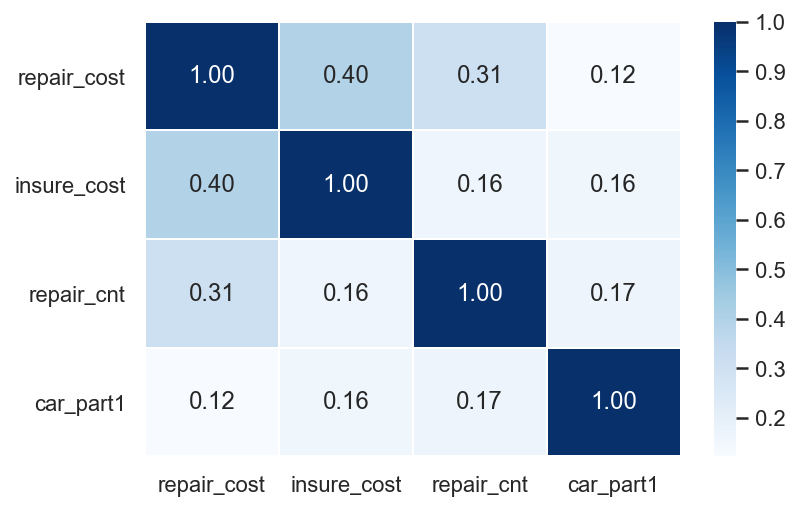

In [266]:
sns.heatmap(df.corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

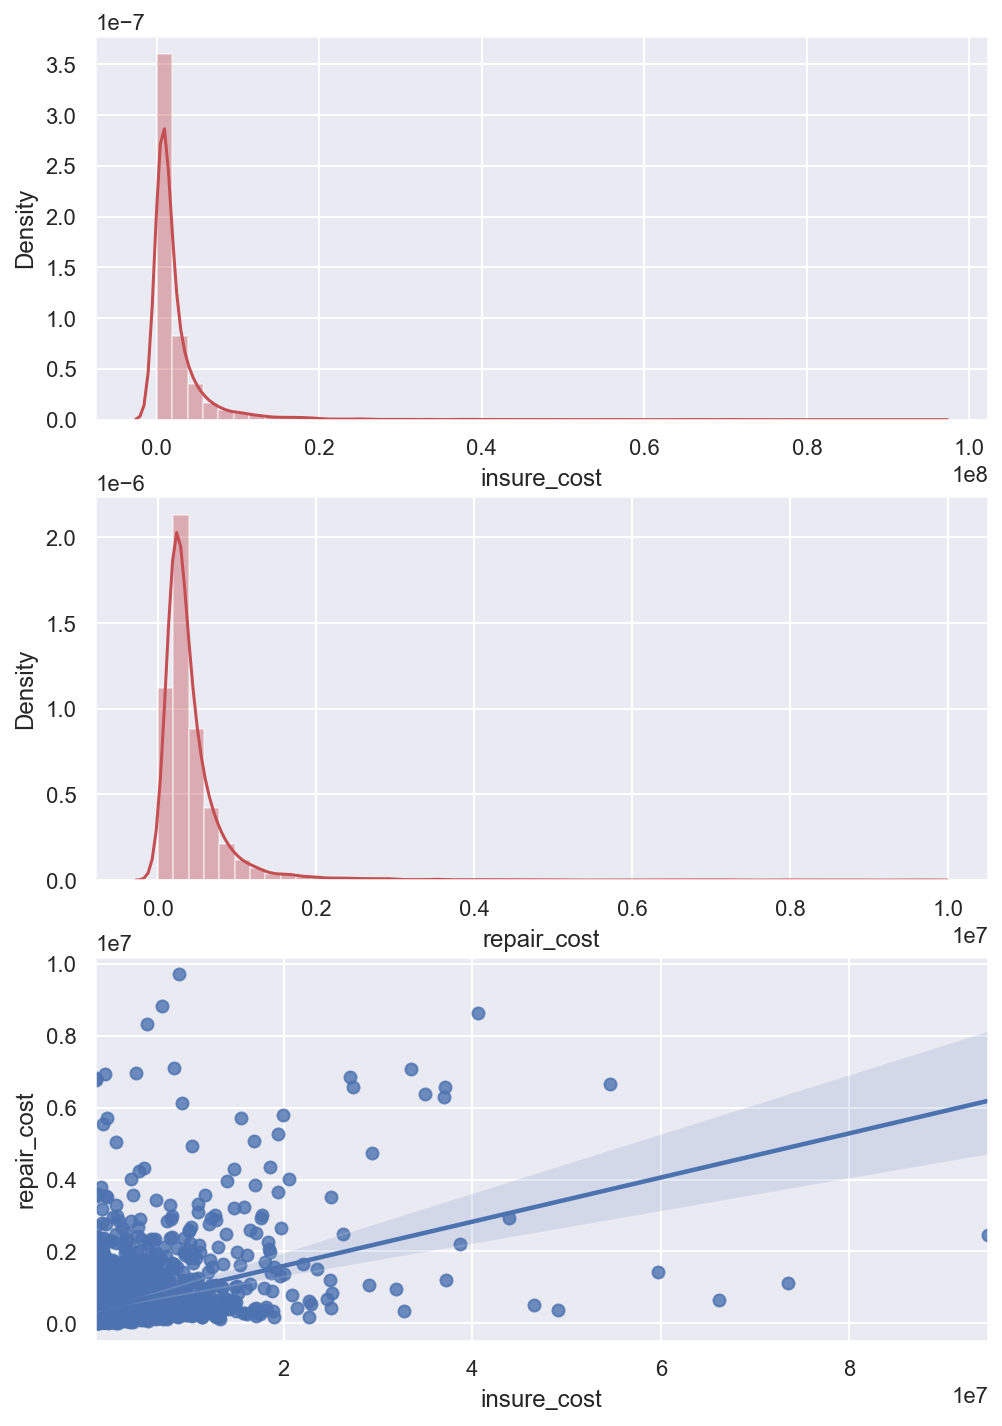

''

In [247]:
f, ax = plt.subplots(3, 1, figsize = (8, 12))

sns.distplot(socar_del["insure_cost"], color="r", ax = ax[0])
sns.distplot(socar_del["repair_cost"], color="r", ax = ax[1])
sns.regplot(x='insure_cost', y='repair_cost', data=socar_del, ax= ax[2])
plt.show()

;